# Fetching the data

In [1]:
# MovieLens 100K
DATASET_LINK = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
!wget -nc $DATASET_LINK

File ‘ml-latest-small.zip’ already there; not retrieving.



In [2]:
!unzip -n ml-latest-small.zip

Archive:  ml-latest-small.zip


# Reading the data

In [3]:
import os
import pandas as pd

BASE_DIR = "ml-latest-small"
RATINGS_FILE = os.path.join(BASE_DIR, "ratings.csv")
MOVIES_FILE = os.path.join(BASE_DIR, "movies.csv")

ratings = pd.read_csv(RATINGS_FILE)
movies = pd.read_csv(MOVIES_FILE)

print(f"Ratings shape: {ratings.shape}")
print(f"Movies shape: {movies.shape}")

Ratings shape: (100836, 4)
Movies shape: (9742, 3)


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Preprocessing

## Merging users and movies

In [6]:
ratings = pd.merge(ratings, movies[["movieId", "title"]], on="movieId")
ratings.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,1,3,4.0,964981247,Grumpier Old Men (1995)
2,1,6,4.0,964982224,Heat (1995)
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,964982931,"Usual Suspects, The (1995)"


## User-movie matrix

In [7]:
# Sorting the users with most movie viewed
users_sorted = ratings.groupby(["userId"]).size().sort_values(ascending=False).index.tolist()
# Sorting the most watched movies
movies_sorted = ratings.groupby(["movieId"]).size().sort_values(ascending=False).index.tolist()

# User-movie matrix
ratings_pivot = ratings.pivot(index="userId", columns="movieId", values="rating")
ratings_pivot.loc[users_sorted[:10], movies_sorted[:10]]

movieId,356,318,296,593,2571,260,480,110,589,527
userId,,,,,,,,,,
414,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0
599,3.5,4.0,5.0,3.0,5.0,5.0,4.0,3.5,4.5,NaN
474,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0
448,3.0,NaN,5.0,5.0,2.0,5.0,3.0,NaN,3.0,NaN
274,4.5,4.5,5.0,4.0,4.0,3.0,3.5,4.5,4.5,4.0
610,3.0,3.0,5.0,4.5,5.0,5.0,5.0,4.5,5.0,3.5
68,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0
380,5.0,3.0,5.0,5.0,4.5,5.0,5.0,4.0,5.0,NaN
606,4.0,3.5,5.0,4.5,5.0,4.5,2.5,3.5,3.5,5.0


# Preprocessing

In [8]:
from typing import Tuple, Optional
import numpy as np


def create_dataset(ratings: pd.DataFrame, top: Optional[int] = None) -> Tuple[Tuple[int, int], Tuple[np.ndarray, np.ndarray], Tuple[dict, dict]]:
    """
    Reindex users and movies and returns:
    - The count of unique users and movies
    - Training data X and y with reindexed users, movies, and ratings
    - The mapping objects for reindexed users and movies

    Args:
        ratings (pd.DataFrame): A DataFrame containing columns `userId`, `movieId`, and `rating`.
        top (Optional[int]): If provided, keeps only the top `N` users by the number of ratings.

    Returns:
        Tuple[Tuple[int, int], Tuple[np.ndarray, np.ndarray], Tuple[dict, dict]]:
            - (n_users, n_movies): Number of unique users and movies.
            - (X, y): Training data where X contains reindexed user and movie indices, and y contains ratings.
            - (user_to_index, movie_to_index): Dictionaries mapping original IDs to reindexed IDs.
    """
    # Filter top users if `top` is provided
    if top is not None:
        user_rating_counts = ratings.groupby("userId")["rating"].count()
        top_users = user_rating_counts.nlargest(top).index
        ratings = ratings[ratings["userId"].isin(top_users)]

    # Create mappings for users and movies
    unique_users = ratings["userId"].unique()
    unique_movies = ratings["movieId"].unique()

    user_to_index = {user: idx for idx, user in enumerate(unique_users)}
    movie_to_index = {movie: idx for idx, movie in enumerate(unique_movies)}

    # Map user and movie IDs to their reindexed values
    user_indices = ratings["userId"].map(user_to_index)
    movie_indices = ratings["movieId"].map(movie_to_index)

    # Count unique users and movies
    n_users = len(unique_users)
    n_movies = len(unique_movies)

    # Create feature matrix X and target vector y
    X = np.column_stack((user_indices, movie_indices))
    y = ratings["rating"].astype(np.float32).values

    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)


(n, m), (X, y), (user_to_index, movie_to_index) = create_dataset(ratings)

In [9]:
print(f"Embeddings: {n} users, {m} movies")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Embeddings: 610 users, 9724 movies
Features shape: (100836, 2)
Target shape: (100836,)


## Train validation split

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Data:")
print(f"Features shape: {X_train.shape} - Target Shape: {y_train.shape}", "\n")
print("Validation Data:")
print(f"Features shape: {X_val.shape} - Target Shape: {y_val.shape}")

Training Data:
Features shape: (80668, 2) - Target Shape: (80668,) 

Validation Data:
Features shape: (20168, 2) - Target Shape: (20168,)


# PyTorch Dataset and Dataloader

In [11]:
import torch
from torch.utils.data import Dataset


class ReviewsDataset(Dataset):
    """
    """
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.users[idx], dtype=torch.long),
            torch.tensor(self.movies[idx], dtype=torch.long),
            torch.tensor(self.ratings[idx], dtype=torch.float)
        )


train_set = ReviewsDataset(X_train[:, 0], X_train[:, 1], y_train)
val_set = ReviewsDataset(X_val[:, 0], X_val[:, 1], y_val)
train_set[:3]

(tensor([508, 325,  56]), tensor([4285, 5629,  134]), tensor([3., 4., 3.]))

In [12]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_set, shuffle=True, batch_size=32)
val_loader = DataLoader(val_set, shuffle=False, batch_size=32)

# Viewing the loading process
for batch in train_loader:
    break
batch

[tensor([  3, 327, 218, 312, 485,  68, 110, 433, 447, 364, 273, 602, 273, 367,
         212, 483, 111, 155, 287,  19, 576, 596, 104, 139,  83, 598,  44, 181,
         139, 384, 361, 527]),
 tensor([  61, 3846, 5751, 1463, 1156, 3497, 1491,   26, 7897, 4549,  685, 4839,
         1429, 4219, 3068,  938,  587, 2419, 1618, 1776,   66,  341,  267, 4900,
           33, 2650,  862,  518, 1027, 3702, 6721,  751]),
 tensor([5.0000, 1.5000, 3.5000, 4.0000, 3.0000, 5.0000, 3.0000, 5.0000, 2.0000,
         3.5000, 2.5000, 5.0000, 4.5000, 2.0000, 4.0000, 4.0000, 4.0000, 2.0000,
         3.0000, 2.0000, 3.0000, 4.0000, 4.0000, 4.0000, 3.0000, 1.5000, 4.0000,
         3.0000, 5.0000, 2.0000, 4.5000, 3.5000])]

# The EmbeddingNet

In [13]:
from typing import List
from itertools import zip_longest
import torch
import torch.nn as nn


# Constants for default values
DEFAULT_N_FACTORS = 50
DEFAULT_EMBEDDING_DROPOUT = 0.02
DEFAULT_HIDDEN_SIZES = [10]
DEFAULT_DROPOUTS = [0.2]


class EmbeddingNet(nn.Module):
    """
    A neural network for generating embeddings for users and movies, and predicting ratings.
    
    Args:
        n_users (int): Number of unique users.
        n_movies (int): Number of unique movies.
        n_factors (int, optional): Number of embedding factors. Defaults to 50.
        embedding_dropout (float, optional): Dropout rate for embeddings. Defaults to 0.02.
        hidden_sizes (List[int], optional): List of sizes for hidden layers. Defaults to [10].
        dropouts (List[float], optional): List of dropout rates for hidden layers. Defaults to [0.2].
    """
    def __init__(self, 
                 n_users: int,
                 n_movies: int,
                 n_factors: int = DEFAULT_N_FACTORS,
                 embedding_dropout: float = DEFAULT_EMBEDDING_DROPOUT, 
                 hidden_sizes: List[int] = DEFAULT_HIDDEN_SIZES,
                 dropouts: List[float] = DEFAULT_DROPOUTS):
        super().__init__()
        self.n_users = n_users
        self.n_movies = n_movies
        self.n_factors = n_factors
        self.embedding_dropout = embedding_dropout

        # Validate dropouts and hidden_sizes
        if len(dropouts) < len(hidden_sizes):
            raise ValueError("dropouts must have at least as many entries as hidden_sizes.")

        # Embedding layers
        self.u = nn.Embedding(self.n_users, self.n_factors)  # Users embeddings
        self.m = nn.Embedding(self.n_movies, self.n_factors)  # Movies embeddings
        self.drop = nn.Dropout(self.embedding_dropout)  # Dropout after embeddings
        
        # Hidden layers construction
        hidden = []
        n_in = self.n_factors * 2
        for n_out, d in zip_longest(hidden_sizes, dropouts):
            hidden.append(nn.Linear(n_in, n_out))
            hidden.append(nn.ReLU())
            if d is not None:
                hidden.append(nn.Dropout(d))
            n_in = n_out
        self.hidden = nn.Sequential(*hidden) # Actual layers
        
        # Output layer
        self.fc = nn.Linear(n_in, 1)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self) -> None:
        """
        Initialize weights for embeddings and hidden layers with reasonable initial values.
        """
        def init(m: nn.Module) -> None:
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)

    def forward(self, 
                users: torch.Tensor, 
                movies: torch.Tensor, 
                minmax: Optional[Tuple[float, float]] = None) -> torch.Tensor:
        """
        Forward pass for the network.
        
        Args:
            users (torch.Tensor): Tensor of user indices.
            movies (torch.Tensor): Tensor of movie indices.
            minmax (Optional[Tuple[float, float]]): Optional tuple of min and max ratings for scaling.
            
        Returns:
            torch.Tensor: Predicted ratings.
        """
        if minmax is not None:
            if len(minmax) != 2:
                raise ValueError(f"minmax must be a tuple with 2 entries but {len(minmax)} was given.")
        
        # Concatenate user and movie embeddings
        features = torch.cat([self.u(users), self.m(movies)], dim=1) # (batch_size, n_factors*2)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))  # Normalize the output to [0, 1]
        
        # Scale output to the desired rating range if minmax is provided
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out * (max_rating - min_rating) + min_rating
            
        return out

In [14]:
torch.manual_seed(42)
net = EmbeddingNet(n_users=n,
                   n_movies=m,
                   n_factors=150,
                   embedding_dropout=0.05,
                   hidden_sizes=[500, 500, 500],
                   dropouts=[0.5, 0.5, 0.25])
net

EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

In [15]:
def count_trainable_params(model: nn.Module) -> int:
    """
    Returns the count of trainable params.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_trainable_params(net):,.0f}")

Trainable parameters: 2,202,101


# Training the model

In [16]:
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 200
N_EPOCHS = 200
PATIENCE = 10
NO_IMPROVEMENTS = 0 # Flag to indicate no improvements
MINMAX = (0.5, 5.0)

In [17]:
import numpy as np
from torch.optim import Optimizer, Adam


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CRITERION = nn.MSELoss()
OPTIMIZER = Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
iterations_per_epoch = int(np.ceil(len(train_set) / BATCH_SIZE))

In [18]:
def run_one_epoch(model: nn.Module, 
                  criterion: nn.Module,
                  dataloader: DataLoader,
                  optimizer: Optional[Optimizer] = None,
                  phase: str = "train",
                  device: Optional[str] = "cpu") -> float:
    """
    Run one epoch of training or evaluation.

    Args:
        model: The neural network model.
        criterion: The loss function.
        dataloader: DataLoader providing the dataset.
        optimizer: Optimizer for training (required if phase is "train").
        phase: Either "train" or "eval" (default: "train").
        device: Device to run the model on (default: "cpu").

    Returns:
        Mean loss over the epoch.
    """
    if phase == "train" and optimizer is None:
        raise ValueError("Optimizer must be provided for training phase.")

    if device is not None:
        model.to(device)

    model.train(phase == "train") # Set model to training or evaluation mode

    running_loss, total_samples = 0.0, 0

    for batch in dataloader:
        users, movies, ratings = batch # Unpack batch
        if device is not None:
            users = users.to(device)
            movies = movies.to(device)
            ratings = ratings.to(device)

        if phase == "train":
            optimizer.zero_grad() # Zero gradients for each batch

        with torch.set_grad_enabled(phase == "train"):
            outputs = model(users=users, movies=movies, minmax=MINMAX)
            loss = criterion(outputs, ratings.view((-1, 1)))

        running_loss += loss.item() * len(y) # Accumulate loss
        total_samples += len(y)

        if phase == "train":
            loss.backward() # Backpropagate
            optimizer.step() # Update weights

    if total_samples == 0:
        raise RuntimeError("No samples processed in the dataloader.")

    return running_loss / total_samples # Return mean loss

In [19]:
import warnings
import copy
from time import perf_counter


def train_model(model: nn.Module, 
                criterion: nn.Module,
                train_set: Dataset,
                optimizer: Optimizer,
                n_epochs: int = 100,
                batch_size: int = 32,
                val_set: Optional[Dataset] = None,
                patience: Optional[int] = None,
                load_best_model: bool = False,
                device: Optional[str] = "cpu") -> list:
    """
    Train a PyTorch model with optional validation and early stopping.

    Args:
        model: The neural network model.
        criterion: The loss function.
        train_set: Training dataset.
        optimizer: Optimizer for training.
        n_epochs: Number of epochs to train (default: 100).
        batch_size: Batch size for training and validation (default: 32).
        val_set: Validation dataset (optional).
        patience: Number of epochs to wait for improvement in validation loss before stopping (optional).
        load_best_model: Whether to load the best model weights after training (default: False).
        device: Device to run the model on (default: "cpu").

    Returns:
        A list of dictionaries containing training and validation loss history.
    """
    if patience is not None and patience < 1:
        raise ValueError("patience must be a positive integer.")
        
    if val_set is None:
        if load_best_model:
            raise ValueError("'load_best_model' requires a validation set.")
        if patience is not None:
            warnings.warn("No validation data was given, so 'patience' will be ignored.")
            
    training_history = []
    best_loss = np.inf
    best_weights = None

    # DataLoaders
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    if val_set is not None:
        val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size)
    
    # Train
    for epoch in range(1, n_epochs + 1):
        model.train()
        start_time = perf_counter()
        train_loss = run_one_epoch(model, criterion, train_loader, optimizer, phase="train", device=device)

        # Evaluation
        val_loss = None
        if val_set is not None:
            model.eval()
            val_loss = run_one_epoch(model, criterion, val_loader, phase="eval", device=device)
        end_time = perf_counter()
        epoch_time = end_time - start_time
        # Log
        training_history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss
        })

        log_string = f"Epoch {epoch} - train_loss: {train_loss:.4f}"
        if val_set is not None:
            log_string += f" - val_loss: {val_loss:.4f}"
        log_string += f" - epoch_time: {epoch_time:.1f}"
        print(log_string)

        # Early stopping
        if patience is not None and val_set is not None:
            if val_loss < best_loss:
                best_loss = val_loss
                best_weights = copy.deepcopy(model.state_dict())
                patience = patience  # Reset patience counter
            else:
                patience -= 1

            # Interrupt training if patience reaches 0
            if patience == 0:
                if load_best_model and best_weights is not None:
                    model.load_state_dict(best_weights)
                break

    # Load best model weights if requested
    if load_best_model and best_weights is not None:
        model.load_state_dict(best_weights)

    return training_history

In [20]:
training_history = train_model(net, CRITERION, train_set, OPTIMIZER, N_EPOCHS, BATCH_SIZE, val_set, PATIENCE, load_best_model=True, device=DEVICE)

Epoch 1 - train_loss: 1.2129 - val_loss: 1.0896
Epoch 2 - train_loss: 1.0732 - val_loss: 1.0727
Epoch 3 - train_loss: 1.0523 - val_loss: 1.0484
Epoch 4 - train_loss: 1.0268 - val_loss: 1.0105
Epoch 5 - train_loss: 0.9833 - val_loss: 0.9585
Epoch 6 - train_loss: 0.9328 - val_loss: 0.9111
Epoch 7 - train_loss: 0.8893 - val_loss: 0.8851
Epoch 8 - train_loss: 0.8638 - val_loss: 0.8667
Epoch 9 - train_loss: 0.8391 - val_loss: 0.8532
Epoch 10 - train_loss: 0.8196 - val_loss: 0.8410
Epoch 11 - train_loss: 0.8031 - val_loss: 0.8309
Epoch 12 - train_loss: 0.7898 - val_loss: 0.8248
Epoch 13 - train_loss: 0.7743 - val_loss: 0.8175
Epoch 14 - train_loss: 0.7637 - val_loss: 0.8123
Epoch 15 - train_loss: 0.7513 - val_loss: 0.8091
Epoch 16 - train_loss: 0.7438 - val_loss: 0.8052
Epoch 17 - train_loss: 0.7342 - val_loss: 0.8017
Epoch 18 - train_loss: 0.7288 - val_loss: 0.7984
Epoch 19 - train_loss: 0.7197 - val_loss: 0.7961
Epoch 20 - train_loss: 0.7146 - val_loss: 0.7943
Epoch 21 - train_loss: 0.7096

In [22]:
training_log = pd.DataFrame(training_history)
training_log.head()

,epoch,train_loss,val_loss
0,1,1.212923,1.089614
1,2,1.073203,1.072732
2,3,1.052291,1.048443
3,4,1.026771,1.010525
4,5,0.983270,0.958463


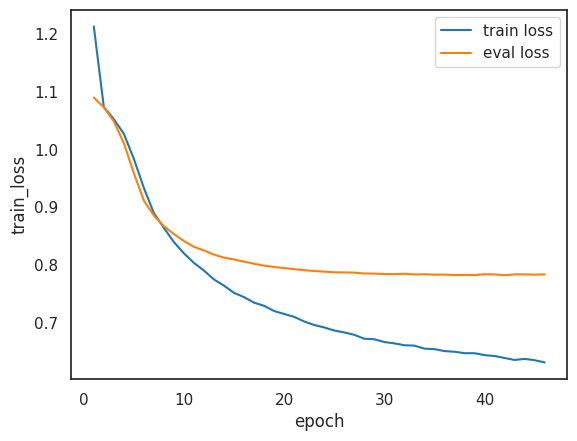

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")


sns.lineplot(training_log, x="epoch", y="train_loss", label="train loss")
sns.lineplot(training_log, x="epoch", y="val_loss", label="eval loss")
plt.show()

In [28]:
from torchmetrics import MeanSquaredError


metric = MeanSquaredError()
net.train(False)
for batch in DataLoader(val_set, shuffle=False, batch_size=100):
    users, movies, ratings = batch
    with torch.no_grad():
        outputs = net(users, movies, MINMAX)
    metric.update(outputs, ratings.view((-1, 1)))
print(f"RMSE: {np.sqrt(metric.compute()):.4f}")

RMSE: 0.8843
